In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
from tqdm import tqdm
import dill

warnings.filterwarnings('ignore')

In [2]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [3]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1941         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [4]:
# ########################### Load Data
# #################################################################################
# print('Load Main Data')

# # We will need only train dataset
# # to show lags concept
train_df = pd.read_csv('data/m5-forecasting-accuracy/sales_train_evaluation.csv')

# # To make all calculations faster
# # we will limit dataset by 'CA' state
# # train_df = train_df[train_df['state_id']=='CA']

## Detrend

In [ ]:
# detrend_sales = []
# bottom_lines = []
# for i in tqdm(range(len(train_df))):
#     lowess = sm.nonparametric.lowess
#     z = lowess(train_df.iloc[i,6:].values, np.arange(1, len(train_df.iloc[i,6:].values)+1))
#     trend = z[:,1]
#     detrend = train_df.iloc[i,6:].values-trend
# #     train_df.iloc[i,6:] = train_df.iloc[i,6:].values-z[:,1]
#     bottom_line = detrend.min()
#     detrend_sales.append(detrend)
#     bottom_lines.append(bottom_line)
# #     print(1)
# #     train_df.iloc[i,6:] = train_df.iloc[i,6:] - bottom_line
# #     if i == 7:
# #         break

In [16]:
# detrend_sales_array = np.concatenate([i.reshape(1,-1) for i in detrend_sales],0)

In [22]:
# detrend_sales_df_evaluation = pd.DataFrame(detrend_sales_array)
# detrend_sales_df_evaluation.index = train_df['id']

In [8]:
# pd.to_pickle(detrend_sales_df_evaluation.reset_index(),'detrend_sales_df_evaluation.pkl')
detrend_sales_df_evaluation = pd.read_pickle('data/m5-detrend/sales_minus_trend_evaluation.pkl')

In [12]:
trend_sales_array = train_df.iloc[:,6:].values-detrend_sales_df_evaluation.iloc[:,1:].values

In [15]:
trend_sales_array

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [1.0612750063022773, 1.0600138068470617, 1.058752965729196, ...,
        0.5214460795688755, 0.521255558969351, 0.5210650163536168],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [-3.684247290720239e-05, -3.678289530277366e-05,
        -3.672317858139696e-05, ..., 2.0503315720055384,
        2.0525535731132547, 2.0547757128090423]], dtype=object)

In [ ]:
# trend_sales_array.shape
dill.dump(trend_sales_array, open('sales_trend.pkl','wb'))

In [8]:
detrend_df = dill.load(open('data/m5-detrend/detrend_sales_df_evaluation.pkl','rb'))

In [ ]:
bottom_line = detrend_df.iloc[:,1:].values.min(1)

In [59]:
train_df.iloc[:,6:] = detrend_df.iloc[:,1:].values+train_df.iloc[:,6:].mean(1).values[:, np.newaxis]-bottom_line[:, np.newaxis]

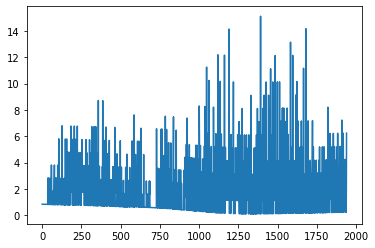

In [54]:
plt.plot(a[3])

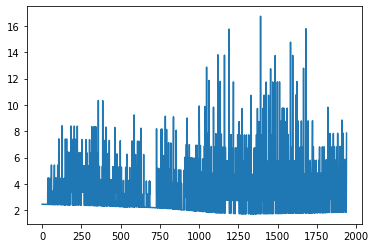

In [60]:
plt.plot(train_df.iloc[3,6:].values)

In [63]:
train_df.to_pickle('data/m5-detrend/final_sales_train_evaluation.pkl')

In [5]:
# ########################### Data Representation
# #################################################################################

# # Let's check our shape
# print('Shape', train_df.shape)

In [8]:
sell_prices = pd.read_csv('data/m5-forecasting-accuracy/sell_prices.csv')
calendar = pd.read_csv('data/m5-forecasting-accuracy/calendar.csv')

In [9]:
calendar['d'] = calendar['d'].str.split('_').apply(lambda x: int(x[1]))
calendar = calendar[['wm_yr_wk','d']].drop_duplicates()

In [10]:
sell_prices['id'] = (sell_prices['item_id'].str.cat(sell_prices['store_id'], sep='_')).str.cat(['evaluation']*len(sell_prices), sep='_')

In [11]:
prices = pd.merge(calendar, sell_prices[['id','wm_yr_wk','sell_price']], on='wm_yr_wk', how='left')
prices = prices[['id','d','sell_price']].drop_duplicates()
prices = prices.set_index(['id','d'])

In [10]:
del calendar, sell_prices
gc.collect()

196

In [ ]:
all_prices = prices.unstack(level=-1, fill_value=0)
all_prices.columns = all_prices.columns.droplevel()
all_prices.index.name = None
all_prices.columns.name = None

In [12]:
# all_prices.to_pickle('all_prices.pkl')
all_prices = pd.read_pickle('all_prices.pkl')

In [ ]:
all_prices.iloc[:,:1941]

In [ ]:
train_df

In [ ]:
# train_df = train_df.set_index('id').loc[all_prices.index]
train_df[train_df.columns[6:]] = train_df[train_df.columns[6:]].values * all_prices.iloc[:,:1941].values

In [ ]:
train_df

In [ ]:
train_df[train_df.columns[5:]].sum()

In [13]:
# all_prices.to_pickle('all_prices.pkl')
# # del all_prices
# del calendar, sell_prices, prices
# gc.collect()

In [14]:
# train_df.reset_index(inplace=True)
# train_df.rename(columns={'index':'id'}, inplace=True)

In [15]:
# ## Horizontal representation

# # If we feed directly this data to model
# # our label will be values in column 'd_1913'
# # all other columns will be our "features"

# # In lag terminology all d_1->d_1912 columns
# # are our lag features 
# # (target values in previous time period)

# # Good thing that we have a lot of features here
# # Bad thing is that we have just 12196 "train rows"
# # Note: here and after all numbers are limited to 'CA' state
# train_df.iloc[:10]

In [16]:
# ## Vertical representation

# # In other hand we can think of d_ columns
# # as additional labels and can significantly 
# # scale up our training set to 23330948 rows

# # Good thing that our model will have 
# # greater input for training
# # Bad thing that we are losing lags that we had
# # in horizontal representation and
# # also new data set consumes much more memory

# index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
# train_df = pd.melt(train_df, 
#                   id_vars = index_columns, 
#                   var_name = 'd', 
#                   value_name = TARGET)

# train_df[train_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:10]

In [17]:
# ## Some minification
# train_df['d'] = train_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# icols = ['id','item_id','dept_id','cat_id','store_id','state_id']
# for col in icols:
#     train_df[col] = train_df[col].astype('category')

In [18]:
# ########################### Lags creation
# #################################################################################

# # We have several "code" solutions here
# # As our dataset is allready sorted by d values
# # we can simply shift() values
# # also we have to keep in mind that 
# # we need to aggregate values on 'id' level

# # group and shift in loop
# temp_df = train_df[['id','d',TARGET]]

# start_time = time.time()
# for i in range(1,8):
#     print('Shifting:', i)
#     temp_df['lag_'+str(i)] = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(i))
    
# print('%0.2f min: Time for loops' % ((time.time() - start_time) / 60))


# # Or same in "compact" manner
# LAG_DAYS = [col for col in range(1,8)]
# temp_df = train_df[['id','d',TARGET]]

# start_time = time.time()
# temp_df = temp_df.assign(**{
#         '{}_lag_{}'.format(col, l): temp_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
#         for l in LAG_DAYS
#         for col in [TARGET]
#     })

# print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

In [19]:
# # The result
# temp_df[temp_df['id']=='HOBBIES_1_001_CA_1_validation'].iloc[:10]

# # You can notice many NaNs values - it's normal
# # because there is no data for day 0,-1,-2
# # (out of dataset time periods)

# # Same works for test set
# # be careful to make lag features:
# # for day 1920 there is no data about day 1919 (until 1913)
# # So if you want to predict day 1915 your 
# # lag features have to start from 2 
# # (1915(predicting day) - 1913(last day with label in dataset))
# # and so on.

# # There are few options to work 
# # with NaNs in train set
# ## 1. drop it train_df[train_df['d']>MAX_LAG_DAY] 
# ## 1.1 in our case we already dropped some lines by release date
# ##     so you have find d.min() for each id
# ##     and drop train_df[train_df['d']>(train_df['d_min']+MAX_LAG_DAY)] 
# ## 2. If you want to keep it you can 
# ##    fill with '-1' to be able to convert to int
# ## 3. Leave as it is
# ## 4. Fill with mean -> not recommended

In [20]:
# ########################### Rolling lags
# #################################################################################

# # We restored some day sales values from horizontal representation
# # as lag features but just few of them (last 7 days or less)
# # because of memory limits we can't have many lag features
# # How we can get additional information from other days?

# ## Rolling aggragations

# temp_df = train_df[['id','d','sales']]

# start_time = time.time()

# for i in [14,30,60]:
#     print('Rolling period:', i)
#     temp_df['rolling_mean_'+str(i)] = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).mean())
#     temp_df['rolling_std_'+str(i)]  = temp_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(1).rolling(i).std())

# # lambda x: x.shift(1)
# # 1 day shift will serve only to predict day 1914
# # for other days you have to shift PREDICT_DAY-1913

# # Such aggregations will help us to restore
# # at least part of the information for our model
# # and out of 14+30+60->104 columns we can have just 6
# # with valuable information (hope it is sufficient)
# # you can also aggregate by max/skew/median etc 
# # also you can try other rolling periods 180,365 etc
# print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))


In [21]:
# # The result
# temp_df[temp_df['id']=='HOBBIES_1_002_CA_1_validation'].iloc[:20]

# # Same for NaNs values - it's normal
# # because there is no data for 
# # 0*(rolling_period),-1*(rolling_period),-2*(rolling_period)

In [22]:
# ########################### Memory ussage
# #################################################################################
# # Let's check our memory usage
# print("{:>20}: {:>8}".format('Original rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# # can we minify it?
# # 1. if our dataset are aligned by index 
# #    you don't need 'id' 'd' 'sales' columns
# temp_df = temp_df.iloc[:,3:]
# print("{:>20}: {:>8}".format('Values rolling df',sizeof_fmt(temp_df.memory_usage(index=True).sum())))

# # can we make it even smaller?
# # carefully change dtype and/or
# # use sparce matrix to minify 0s
# # Also note that lgbm accepts matrixes as input
# # that is good for memory reducion 
# from scipy import sparse 
# temp_matrix = sparse.csr_matrix(temp_df)

# # restore to df
# temp_matrix_restored = pd.DataFrame(temp_matrix.todense())
# restored_cols = ['roll_' + str(i) for i in list(temp_matrix_restored)]
# temp_matrix_restored.columns = restored_cols

In [23]:
# ########################### Remove old objects
# #################################################################################
# del temp_df, train_df, temp_matrix, temp_matrix_restored

In [4]:
grid_df = pd.read_pickle('data/m5-detrend/grid_part_1.pkl')

In [5]:
grid_df.loc[46035375]

id          HOUSEHOLD_2_225_CA_3_evaluation
item_id                     HOUSEHOLD_2_225
dept_id                         HOUSEHOLD_2
cat_id                            HOUSEHOLD
store_id                               CA_3
state_id                                 CA
d                                      1914
sales                               4.87969
release                                 247
Name: 46035375, dtype: object

In [13]:
prices.reset_index(inplace=True)

In [14]:
grid_df = pd.merge(grid_df,prices,on=['id','d'],how='left')

In [15]:
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,21.724774,0,0.46
1,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,3.178102,0,1.56
2,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,1.051045,0,3.17
3,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,1,0.407973,0,5.98
4,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,1,10.214727,0,0.70
5,HOBBIES_1_016_CA_1_evaluation,HOBBIES_1_016,HOBBIES_1,HOBBIES,CA_1,CA,1,12.000289,0,0.70
6,HOBBIES_1_022_CA_1_evaluation,HOBBIES_1_022,HOBBIES_1,HOBBIES,CA_1,CA,1,2.337870,0,6.86
7,HOBBIES_1_023_CA_1_evaluation,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_1,CA,1,3.127080,0,3.44
8,HOBBIES_1_028_CA_1_evaluation,HOBBIES_1_028,HOBBIES_1,HOBBIES,CA_1,CA,1,0.704276,0,6.67
9,HOBBIES_1_029_CA_1_evaluation,HOBBIES_1_029,HOBBIES_1,HOBBIES,CA_1,CA,1,3.976791,0,7.44


In [16]:
grid_df['sales'] = grid_df['sales'].values * grid_df['sell_price'].values

In [17]:
grid_df.drop(columns=['sell_price'], inplace=True)

In [18]:
grid_df.loc[46035375]

id          HOUSEHOLD_2_225_CA_3_evaluation
item_id                     HOUSEHOLD_2_225
dept_id                         HOUSEHOLD_2
cat_id                            HOUSEHOLD
store_id                               CA_3
state_id                                 CA
d                                      1914
sales                               4.53812
release                                 247
Name: 46035375, dtype: object

In [19]:
########################### Apply on grid_df
#################################################################################
# lets read grid from 
# https://www.kaggle.com/kyakovlev/m5-simple-fe
# to be sure that our grids are aligned by index
# grid_df = pd.read_pickle('../input/m5-simple-fe/grid_part_1.pkl')

# We need only 'id','d','sales'
# to make lags and rollings
grid_df = grid_df[['id','d','sales']]

###
SHIFT_DAY = 28
# SHIFT_DAY = 1
###


# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+28)]
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')
###
# for i in [7,14,30,60,180]:
#     print('Rolling period:', i)
#     grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
#     grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
###

###
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
###
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create lags
14.01 min: Lags
Create rolling aggs
Shifting period: 1
Shifting period: 7
Shifting period: 14
8.68 min: Lags


In [55]:
ha = pd.read_pickle('data/m5-lags-features/lags_df_28.pkl')

In [20]:
########################### Export
#################################################################################
print('Save lags and rollings')
grid_df.to_pickle('data/m5-detrend/lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [21]:
########################### Final list of new features
#################################################################################
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47735397 entries, 0 to 47735396
Data columns (total 43 columns):
id                        object
d                         int16
sales                     float64
sales_lag_28              float16
sales_lag_29              float16
sales_lag_30              float16
sales_lag_31              float16
sales_lag_32              float16
sales_lag_33              float16
sales_lag_34              float16
sales_lag_35              float16
sales_lag_36              float16
sales_lag_37              float16
sales_lag_38              float16
sales_lag_39              float16
sales_lag_40              float16
sales_lag_41              float16
sales_lag_42              float16
sales_lag_43              float16
sales_lag_44              float16
sales_lag_45              float16
sales_lag_46              float16
sales_lag_47              float16
sales_lag_48              float16
sales_lag_49              float16
sales_lag_50              float16
sale